# Chrip Pulse Simulation and Processing

In [242]:
# Imports

using PyPlot
using FFTW

## 1. Chirp Pulse Creation

**Creating the chirp**

In [243]:
c = 343; # Speed of sound in air in m/s
fs =44100; # This is the sample rate of the sonar.
dt = 1/fs; # This is the sample spacing
r_max = 20; # Maximum range in metres to which to simulate.
t_max = 2*r_max/c; # Time delay to max range

# Create an array containing the time values of the samples
t = collect(0:dt:t_max); # t=0:dt:t_max defines a "range".
r = c*t/2;

# NOW create the chirp pulse, shifted by an amount td, to start at
# some time td-T/2>0. 
f0 = 10000; # Centre frequency is 10 kHz
B = 4000; # Chirp bandwidth
T = 5E-3; # Chirp pulse length
K = B/T; # Chirp rate

# Define a simple a rect() function which returns for -0.5<=t<=0.5 or 0.
# The function will work if t is an array of values.
rect(t) = (abs.(t) .<= 0.5)*1.0

# rect(t/T) spans the interval [-T/2,T/2]
# We must therefore delay the chirp pulse so that it starts after t=0.
# Shift the chirp pulse by 0.6T units to the right, so that it starts at 0.1*T

td = 0.51*T; # Chirp delay
v_tx = cos.( 2*pi*(f0*(t .- td) + 0.5*K*(t .- td).^2) ) .* rect.((t .-td)/T);

**Chrip in the time domain**

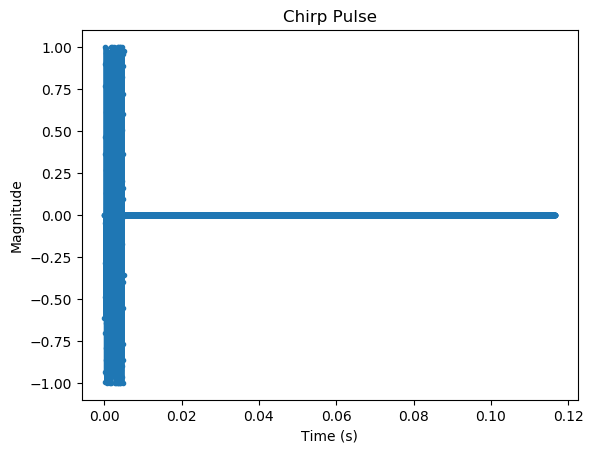

In [244]:
figure();
title("Chirp Pulse");
xlabel("Time (s)");
ylabel("Magnitude");
plot(t,v_tx,".-");

**Chirp in the frequency domain**

In [245]:
#Label the frequency axis in Hz
N = length(t);
Δf = 1/(N*dt); # spacing in frequency domain

#create array of freq values stored in f_axis. First element maps to 0Hz
if mod(N,2)==0 # case N even
    f_axis = (-N/2:N/2-1)*Δf;
else # case N odd
    f_axis = (-(N-1)/2 : (N-1)/2)*Δf;
end

# Get the fourier transform
V_TX = fft(v_tx);

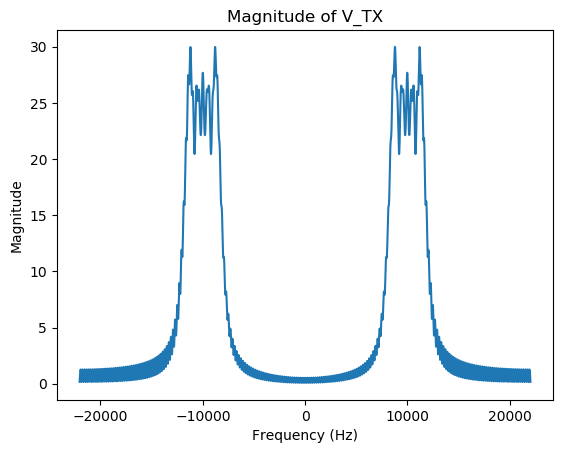

In [246]:
figure()
title("Magnitude of V_TX")
xlabel("Frequency (Hz)")
ylabel("Magnitude")

plot(f_axis,fftshift(abs.(V_TX)),"-");

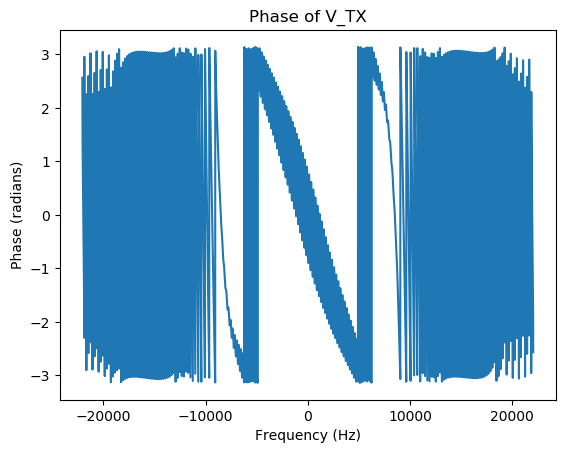

In [247]:
figure()
title("Phase of V_TX")
xlabel("Frequency (Hz)")
ylabel("Phase (radians)")

plot(f_axis,fftshift(angle.(V_TX)),"-");

## 2. Point Target Simulation

In [248]:
R1 = 3 # My range to target.
td1 = 2*R1/c; # two way delay to target.
A1 = 1/R1^2; # echo voltage signal proportional to 1/R^2

v_rx = A1*cos.( 2*pi*(f0*(t.-td.-td1) + 0.5*K*(t.-td.-td1).^2) ) .* rect((t.-td.-td1)/T);
V_RX = fft(v_rx);

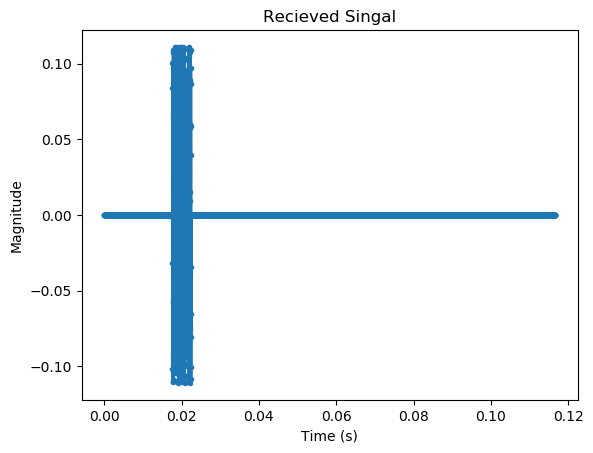

In [249]:
figure();
title("Recieved Singal");
xlabel("Time (s)");
ylabel("Magnitude");
plot(t,v_rx,".-");

## 3. Matched Filtering

In [250]:
H = conj( V_TX); # Create a mathced filter

V_MF = H.*V_RX; # Apply the matched filter to the simulated return 
v_mf = ifft(V_MF);

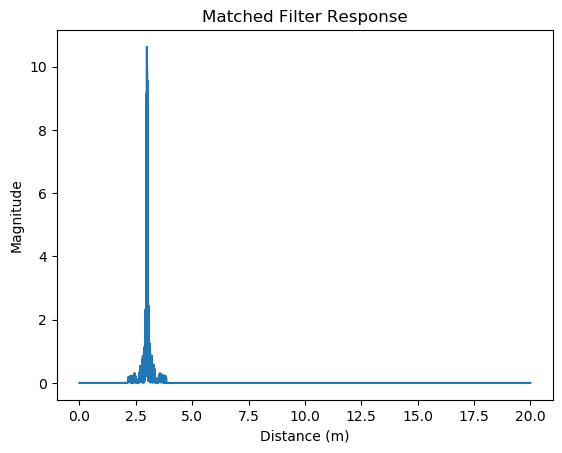

In [251]:
figure();
title("Matched Filter Response");
xlabel("Distance (m)");
ylabel("Magnitude");
plot(r,abs.(v_mf),"-");

## 4. Creating an Analytic Signal

In [252]:
# Creaing and analytic signal involves zeroing out the negative frequency
# components (i.e. the second half of the frequency array), and inverse transform to obtain the
# analytic signal:

V_ANAL = 2*V_MF; # make a copy and double the values
N = length(V_MF);

if mod(N,2)==0 # case N even
 neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
 neg_freq_range = Int((N+1)/2):N;
end
V_ANAL[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal = ifft(V_ANAL);

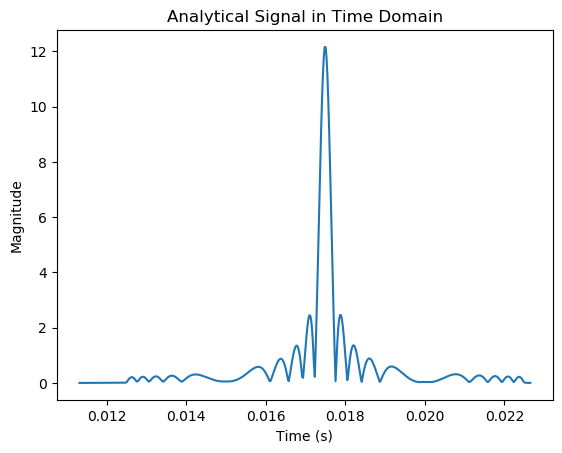

In [253]:
figure()
title("Analytical Signal in Time Domain")
xlabel("Time (s)")
ylabel("Magnitude")
plot(t[500:1000],abs.(v_anal)[500:1000]);

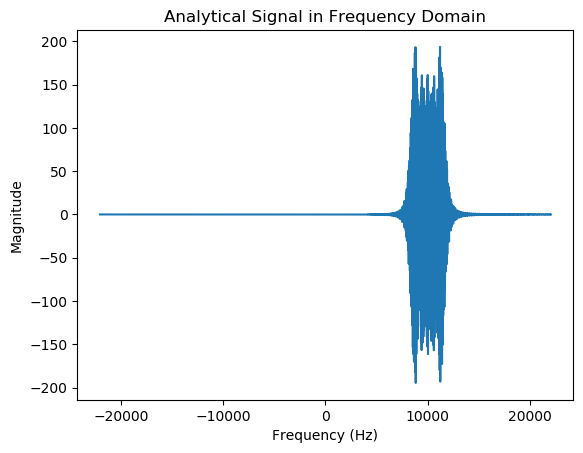

In [254]:
figure()
title("Analytical Signal in Frequency Domain")
xlabel("Frequency (Hz)")
ylabel("Magnitude")
plot(f_axis,fftshift(V_ANAL));

## 5. Translating to Baseband

In [255]:
j=im; # Assign j as sqrt(-1) (“im” in julia)
v_bb = v_anal.*exp.(-j*2*pi*f0*t);

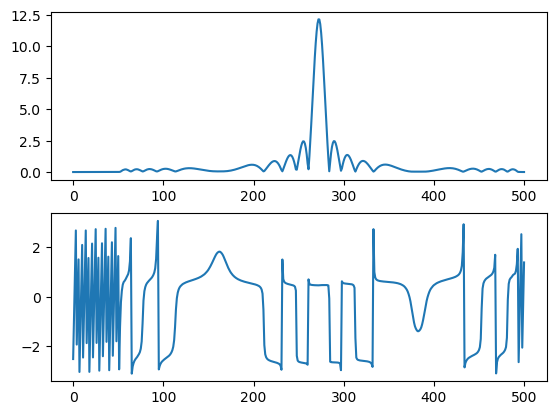

In [256]:
# To see the magnitude and phase – zoom in to have a good look.
figure()
subplot(2,1,1)
plot(abs.(v_bb)[500:1000])
subplot(2,1,2)
plot(angle.(v_bb)[500:1000]); # Notice that the phase is constant over the sidelobe

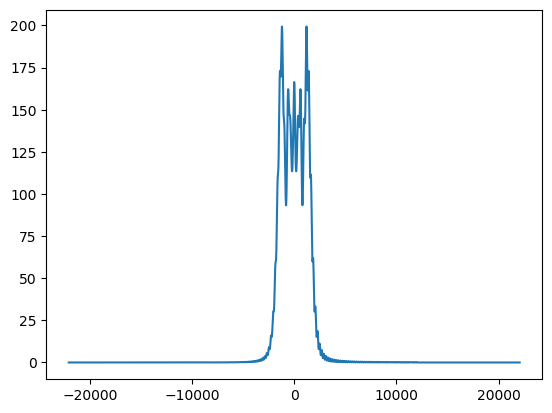

In [258]:
V_BB = fft(v_bb); ;
plot(f_axis,fftshift(abs.(V_BB)));